# Nakagami V1 - cGAN

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]= "3"

import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.special import gamma, gammaincinv

np.random.seed(1234) # The random seed could be different from what we used for the paper.

2023-12-10 01:47:07.784420: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 01:47:07.826807: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 01:47:08.743053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Core functions

In [2]:
class NakagamiV1:
    def __init__(self, m:int=1, eta:float=1, d_0:int=100, d:int=200, alpha:int=2, 
                 QAM:np.ndarray=np.asarray([-3 - 3j, -3 - 1j, -3 + 1j, -3 + 3j, -1 - 3j, -1 - 1j, -1 + 1j, -1 + 3j,
                        1 - 3j, 1 - 1j, 1 + 1j, 1 + 3j, 3 - 3j, 3 - 1j, 3 + 1j, 3 + 3j], dtype=np.complex64)):
        self.m = m
        self.eta = eta
        self.d_0 = d_0
        self.d = d
        self.alpha = alpha
        self.QAM = QAM
    
    # Will use this to notify whether it is positive, negative or zero
    def sign_checker(self, numeric_value):
        if numeric_value > 0 :
            return 1
        
        elif numeric_value == 0:
            return 0
        
        elif numeric_value < 0:
            return -1
    
    def sign_checker_array(self, target_array):
        # Use a list comprehension to apply the sign_checker function to each element in target_array
        sign_array = np.array([self.sign_checker(x) for x in target_array])
        
        return sign_array
    
    def generate(self, number:int=10000, use_balanced_r:bool=False, balanced_r_real=None, balanced_r_imaginary=None):
        r_real = np.random.uniform(size=number)
        r_imaginary = np.random.uniform(size=number)
        
        # randomly chose one of the signals : Its QAM 16, but start without negative values for the calculation
        labels_index = np.random.choice(len(self.QAM), number)
        Pt = self.QAM[labels_index]

        Pr_d = Pt * self.eta * np.power((self.d_0/self.d), self.alpha)
        
        RHS_real = gammaincinv(self.m, gamma(self.m)*r_real) / self.m
        RHS_imaginary = gammaincinv(self.m, gamma(self.m)*r_imaginary) / self.m
        
        data_real = np.real(Pr_d) * RHS_real
        data_imaginary = np.imag(Pr_d) * RHS_imaginary
        
        sign_data_real = self.sign_checker_array(data_real)
        sign_data_imaginary = self.sign_checker_array(data_imaginary)
        
        # Without Noise
        nakagami_real = sign_data_real * np.sqrt(abs(data_real)) 
        nakagami_imaginary = sign_data_imaginary * np.sqrt(abs(data_imaginary))
        
        # without 1j
        nakagami_complex = np.hstack([nakagami_real.reshape(number, 1), nakagami_imaginary.reshape(number, 1)])
        
        # condition = np.hstack([np.real(Pt), np.imag(Pt), np.asarray([RHS_real]), np.asarray([RHS_imaginary])])
        condition = np.hstack([np.real(Pt).reshape(number, 1)/3, np.imag(Pt).reshape(number, 1)/3, 
                               r_real.reshape(number, 1), r_imaginary.reshape(number, 1)])
        
        return nakagami_complex, condition, np.expand_dims(labels_index, axis=1)

In [3]:
class NakagamiV1Evaluator(NakagamiV1):
    def __init__(self):
        # Refer NakagamiV2
        super().__init__()
    
    def validate_mean(self):
        
        list_ideal_mean = list()
        
        for idx in range(len(self.QAM)):
            Pt = self.QAM[idx]
            
            Pr_d_real = np.real(Pt) * self.eta * (self.d_0/self.d)**self.alpha
            Pr_d_imaginary = np.imag(Pt) * self.eta * (self.d_0/self.d)**self.alpha
            
            ## memorize whether it is negative, zero, or positive : -1 or 0 or 1 
            ## because np.sqrt(netative_value) not working - but the abs values are the same
            sign_Pr_d_real = self.sign_checker(Pr_d_real)
            sign_Pr_d_imaginary = self.sign_checker(Pr_d_imaginary)
            
            ideal_mean_real = (gamma(self.m + 1/2)/gamma(self.m)) * (sign_Pr_d_real*np.sqrt(abs(Pr_d_real)/self.m))
            ideal_mean_imaginary = (gamma(self.m + 1/2)/gamma(self.m)) * (sign_Pr_d_imaginary*np.sqrt(abs(Pr_d_imaginary)/self.m))

            list_ideal_mean.append(np.hstack((ideal_mean_real, ideal_mean_imaginary)))
            
        return np.asarray(list_ideal_mean)
    
    def validate_var(self):
        
        list_ideal_var = list()
        
        for idx in range(len(self.QAM)):

            Pt = self.QAM[idx]
            Pr_d = Pt * self.eta * (self.d_0/self.d)**self.alpha

            RHS = (1 - (1/self.m) * np.power((gamma(self.m + 1/2)/gamma(self.m)), 2))
            
            ideal_var_real = abs(np.real(Pr_d)) * RHS
            ideal_var_imaginary = abs(np.imag(Pr_d)) * RHS
            
            list_ideal_var.append(np.hstack((ideal_var_real, ideal_var_imaginary)))
        
        return np.asarray(list_ideal_var)

## Genuine Data Generation

In [4]:
con = NakagamiV1()

In [5]:
data_for_ai, condition_for_ai, indices_array = con.generate(number=1080000)

## Genuine Data Evaluation

In [6]:
df_genuine = pd.DataFrame(data=np.hstack((data_for_ai, indices_array)), columns=['real', 'imaginary', 'QAM'])
df_genuine

,real,imaginary,QAM
0,0.230542,-0.226998,9.0
1,-0.854319,0.679017,3.0
2,0.379397,-0.288766,9.0
3,1.074286,0.495384,14.0
4,0.615227,0.609021,10.0
...,...,...,...
1079995,-0.306809,0.688995,3.0
1079996,-0.435399,-0.978913,4.0
1079997,1.378059,-1.304323,12.0
1079998,0.517224,-0.997700,8.0


### Calculate the Ideal mean and var of the Nakagami

In [7]:
df_ideal_mean = pd.DataFrame(data=NakagamiV1Evaluator().validate_mean(), columns=['ideal_real', 'ideal_imaginary'])
df_ideal_mean

,ideal_real,ideal_imaginary
0,-0.767495,-0.767495
1,-0.767495,-0.443113
2,-0.767495,0.443113
3,-0.767495,0.767495
4,-0.443113,-0.767495
5,-0.443113,-0.443113
6,-0.443113,0.443113
7,-0.443113,0.767495
8,0.443113,-0.767495
9,0.443113,-0.443113


In [8]:
df_ideal_var = pd.DataFrame(data=NakagamiV1Evaluator().validate_var(), columns=['ideal_real', 'ideal_imaginary'])
df_ideal_var

,ideal_real,ideal_imaginary
0,0.160951,0.160951
1,0.160951,0.053650
2,0.160951,0.053650
3,0.160951,0.160951
4,0.053650,0.160951
5,0.053650,0.053650
6,0.053650,0.053650
7,0.053650,0.160951
8,0.053650,0.160951
9,0.053650,0.053650


### Comparing Genuine Data and Ideal Data

#### Mean

In [9]:
df_mean_comp = pd.concat([df_genuine.groupby('QAM').mean(), df_ideal_mean], axis=1)
df_per_diff_mean_real = (((df_mean_comp['real'] - df_mean_comp['ideal_real']) / df_mean_comp['ideal_real']) * 100).round(2)
df_per_diff_mean_imaginary = (((df_mean_comp['imaginary'] - df_mean_comp['ideal_imaginary']) / df_mean_comp['ideal_imaginary']) * 100).round(2)
df_per_diff_mean_dict = {'per_diff_real_%':df_per_diff_mean_real, 'per_diff_imaginary_%':df_per_diff_mean_imaginary}
df_mean_comp_final = pd.concat([df_mean_comp, pd.DataFrame(df_per_diff_mean_dict)], axis=1)
df_mean_comp_final[df_mean_comp_final.columns[[0, 2, 4, 1, 3, 5]]]

,real,ideal_real,per_diff_real_%,imaginary,ideal_imaginary,per_diff_imaginary_%
0.0,-0.765747,-0.767495,-0.23,-0.767646,-0.767495,0.02
1.0,-0.767718,-0.767495,0.03,-0.444093,-0.443113,0.22
2.0,-0.767689,-0.767495,0.03,0.443459,0.443113,0.08
3.0,-0.766800,-0.767495,-0.09,0.766016,0.767495,-0.19
4.0,-0.443898,-0.443113,0.18,-0.768242,-0.767495,0.10
5.0,-0.442202,-0.443113,-0.21,-0.443916,-0.443113,0.18
6.0,-0.443005,-0.443113,-0.02,0.442678,0.443113,-0.10
7.0,-0.442473,-0.443113,-0.14,0.769024,0.767495,0.20
8.0,0.445285,0.443113,0.49,-0.767932,-0.767495,0.06
9.0,0.443478,0.443113,0.08,-0.443016,-0.443113,-0.02


#### Variance

In [10]:
df_var_comp = pd.concat([df_genuine.groupby('QAM').var(), df_ideal_var], axis=1)
df_per_diff_var_real = (((df_var_comp['real'] - df_var_comp['ideal_real']) / df_var_comp['ideal_real']) * 100).round(2)
df_per_diff_var_imaginary = (((df_var_comp['imaginary'] - df_var_comp['ideal_imaginary']) / df_var_comp['ideal_imaginary']) * 100).round(2)
df_per_diff_var_dict = {'per_diff_real_%':df_per_diff_var_real, 'per_diff_imaginary_%':df_per_diff_var_imaginary}
df_var_comp_final = pd.concat([df_var_comp, pd.DataFrame(df_per_diff_var_dict)], axis=1)
df_var_comp_final[df_var_comp_final.columns[[0, 2, 4, 1, 3, 5]]]

,real,ideal_real,per_diff_real_%,imaginary,ideal_imaginary,per_diff_imaginary_%
0.0,0.159015,0.160951,-1.20,0.160875,0.160951,-0.05
1.0,0.161413,0.160951,0.29,0.054111,0.053650,0.86
2.0,0.161138,0.160951,0.12,0.053762,0.053650,0.21
3.0,0.161944,0.160951,0.62,0.161061,0.160951,0.07
4.0,0.052932,0.053650,-1.34,0.161270,0.160951,0.20
5.0,0.053819,0.053650,0.31,0.053998,0.053650,0.65
6.0,0.053363,0.053650,-0.54,0.053838,0.053650,0.35
7.0,0.053331,0.053650,-0.60,0.160207,0.160951,-0.46
8.0,0.053880,0.053650,0.43,0.160249,0.160951,-0.44
9.0,0.053946,0.053650,0.55,0.053508,0.053650,-0.27


# AI modeling

In [11]:
import tensorflow as tf
from keras.layers import Input, Flatten, multiply, BatchNormalization, Dropout
from keras.layers import Dense, Embedding
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras import backend as K

## cGAN

In [12]:
class cGAN_V1():
    def __init__(self):
        self.Z_dim = 16
        self.condition_dim = 4
        self.condition_depth = 2
        
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5)
        
        # Discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        # Generator
        self.generator = self.build_generator()
        
        z = Input(shape=(self.Z_dim, ))
        label = Input(shape=(self.condition_dim, ))
        signal = self.generator([z, label])
        
        self.discriminator.trainable = False
        prediction = self.discriminator([signal, label])
        
        self.cgan = Model([z, label], prediction)
        self.cgan.compile(loss='binary_crossentropy',
                           optimizer=optimizer,
                           metrics=['accuracy'])
    
    def build_generator(self):
        model = Sequential()

        model.add(Dense(512, activation='gelu', input_shape=(self.Z_dim + self.condition_dim, )))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu')) # 16 + 4
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(2)) # condition_depth
        
        z = Input(shape=(self.Z_dim, ))
        label = Input(shape=(self.condition_dim, ))

        z_label_combined = tf.concat([z, label], 1)

        signal = model(z_label_combined)
        model.summary()

        return Model([z, label], signal)
        
    def build_discriminator(self):
        model = Sequential()
        
        model.add(Dense(64, activation='gelu', input_shape=(self.condition_depth + self.condition_dim, )))
        
        model.add(Dense(64, activation='gelu'))
        
        model.add(Dense(64, activation='gelu'))
        
        model.add(Dense(64, activation='gelu'))
        
        model.add(Dense(64, activation='gelu'))

        model.add(Dense(1, activation='sigmoid'))

        signal = Input(shape=self.condition_depth, )
        label = Input(shape=(self.condition_dim, ))

        signal_label_combined = tf.concat([signal, label], 1)

        prediction = model(signal_label_combined)
        model.summary()

        return Model([signal, label], prediction)
    
    def train(self, epochs:int, short_cut:str, batch_size:int=32, save_interval:int=100):
        epochs += 1
        
        try:
            from IPython.display import clear_output
        except ImportError:
            print("Please do ..")
            print("!pip install ipython")
            print("This is to clear the output periodically")
        
        if os.path.exists(short_cut):
            print(f'Directory is already existed!!')
            return None
            
        signal_x = data_for_ai
        label_y = condition_for_ai
        
        data_size = len(label_y)
        
        real = np.ones(shape=(batch_size, 1))
        fake = np.zeros(shape=(batch_size, 1))
        
        for iteration in range(epochs):
            
            idx = np.random.randint(0, signal_x.shape[0], batch_size)
            signals, labels = signal_x[idx], label_y[idx]

            Z = np.random.normal(0, 1, size=(batch_size, self.Z_dim))
            gen_signals = self.generator.predict([Z, labels])

            d_loss_real = self.discriminator.train_on_batch([signals, labels], real)
            d_loss_fake = self.discriminator.train_on_batch([gen_signals, labels], fake)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            g_loss = self.cgan.train_on_batch([Z, labels], real)

            if (iteration) % save_interval == 0:
                
                if iteration % 1500 == 0:
                    clear_output(wait=True)
        
                print(f"{iteration} [D loss: {d_loss[0]}, accuracy: {(100 * d_loss[1]): .2f}]  |  [G loss: {g_loss[0]}]")

                if iteration == 0:
                    pass

                else :
                    if not os.path.exists(short_cut):
                        os.makedirs(short_cut)
                        os.makedirs(f'{short_cut}/gen')
                        os.makedirs(f'{short_cut}/dis')
                        os.makedirs(f'{short_cut}/gan')

                    with open(f'{short_cut}/d_loss.txt', 'a') as f:
                        f.write(str(round((d_loss[0]), 7)))
                        f.write(', ')
                    with open(f'{short_cut}/g_loss.txt', 'a') as f:
                        f.write(str(round((g_loss[0]), 7)))
                        f.write(', ')
                    with open(f'{short_cut}/accuracy.txt', 'a') as f:
                        f.write(str(f"{(100 * d_loss[1]):.2f}"))
                        f.write(', ')
                        
                self.generator.save(f'{short_cut}/gen/generator_{iteration}.h5')
                self.discriminator.save(f'{short_cut}/dis/discriminator_{iteration}.h5')


In [13]:
epochs = 2
save_interval = 1 #epochs

version = "cGAN"
nakagami_version = "Ap1"
my_short_cut = f"/home/ylee/wts2024_git/{nakagami_version}/{version}"

# Train
cGAN_V1().train(epochs=epochs, short_cut=my_short_cut, save_interval=save_interval)

2023-12-10 01:47:19.737782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:e3:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,153
Trainable params: 17,153
Non-traina

## Evaluation

### Generate data

In [15]:
with open(f"{my_short_cut}/g_loss.txt", "r") as file1:
    gen_loss = file1.readline().strip().split(",")

with open(f"{my_short_cut}/d_loss.txt", "r") as file2:
    dis_loss = file2.readline().strip().split(",")
    
gen_loss = [float(value) for value in gen_loss if value.strip()]
dis_loss = [float(value) for value in dis_loss if value.strip()]

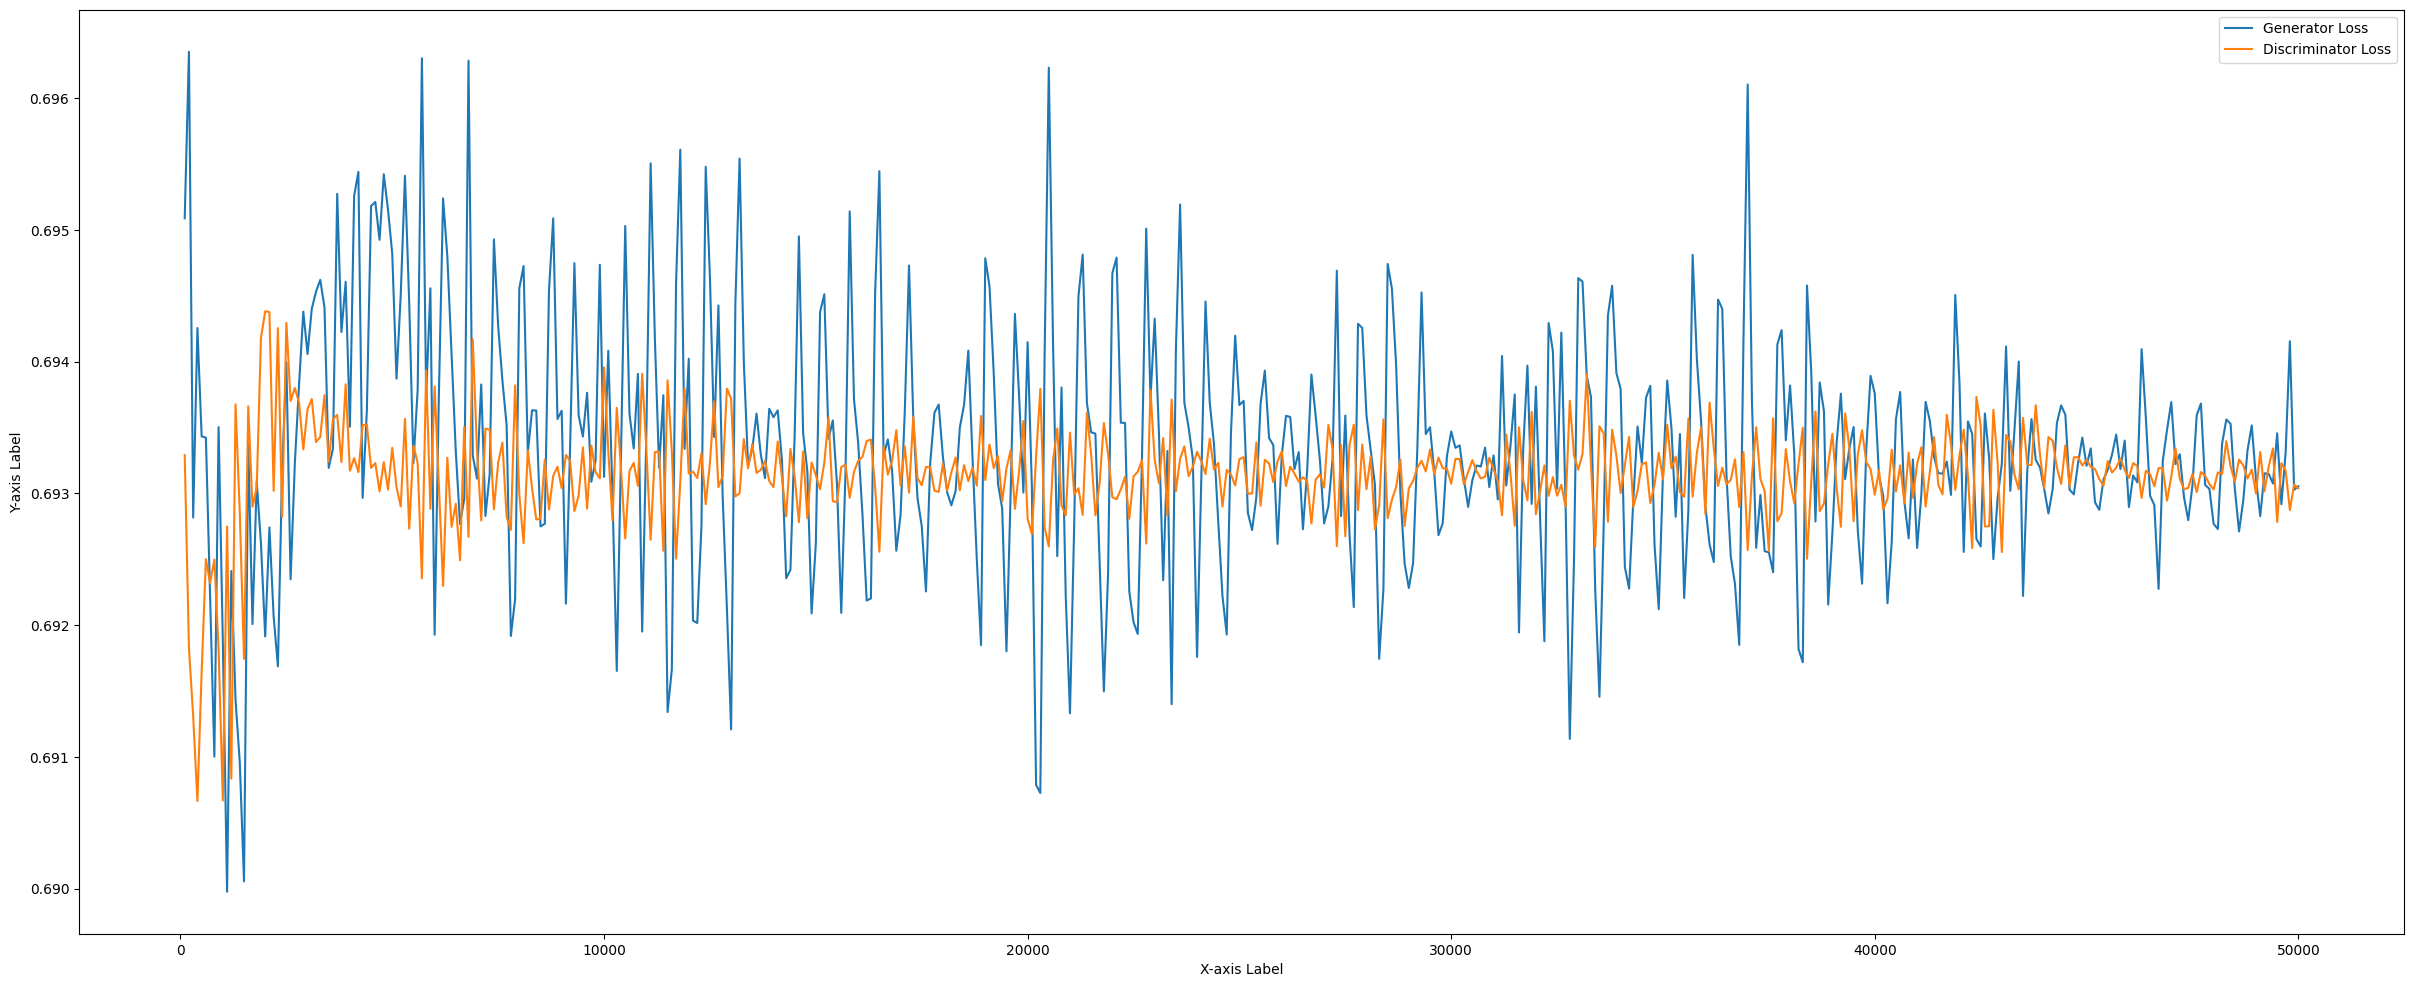

In [16]:
plt.figure(figsize=(30, 12))

x = np.arange(save_interval, epochs+1, save_interval)

plt.plot(x, gen_loss, label="Generator Loss")
plt.plot(x, dis_loss, label="Discriminator Loss")

plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label")
plt.legend()

plt.show()

## Calculate ScaledPE for the entire models

In [17]:
import sys
import os
import importlib
sys.path.append('/.')

import model_eval_git
importlib.reload(model_eval_git)
df_comp_result = model_eval_git.get_the_best_model_cgan_v1(class_NakagamiV1_cgan=con, target_model_dir=f"{my_short_cut}", 
                                                       save_interval=save_interval, Z_dim=cGAN_V1().Z_dim, custom_metric=False, 
                                                        target_df_ideal_mean=df_ideal_mean, target_df_ideal_var=df_ideal_var)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                448       
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,153
Trainable params: 17,153
Non-trai

In [18]:
df_comp_result = pd.read_csv(f"{my_short_cut}/info_all_models.csv")
df_comp_result

,epoch,real_mean_avg,imaginary_mean_avg,real_var_avg,imaginary_var_avg
0,0.0,100.505625,100.124375,99.874375,99.832500
1,100.0,82.033125,84.081875,1408.914375,1302.001250
2,200.0,66.751875,71.283750,887.690000,797.906875
3,300.0,59.743125,68.700000,644.678750,594.026875
4,400.0,52.641250,59.809375,560.980000,481.831250
...,...,...,...,...,...
496,49600.0,9.017500,8.311250,51.541875,40.097500
497,49700.0,8.413750,12.403125,32.735625,36.168125
498,49800.0,16.947500,5.622500,29.525625,23.793750
499,49900.0,14.283750,6.440000,28.823125,18.824375


In [19]:
ratio_mean_avg = 0.3
ratio_var_avg = 1 - ratio_mean_avg
df_comp_result['mean_avg'] = (df_comp_result['real_mean_avg'] + df_comp_result['imaginary_mean_avg'])/2
df_comp_result['var_avg'] = (df_comp_result['real_var_avg'] + df_comp_result['imaginary_var_avg'])/2
df_comp_result['scaled_weight'] = (df_comp_result['mean_avg']*ratio_mean_avg + df_comp_result['var_avg']*ratio_var_avg)/2

In [20]:
df_comp_result.sort_values(by='mean_avg', ascending=True).head(10)

,epoch,real_mean_avg,imaginary_mean_avg,real_var_avg,imaginary_var_avg,mean_avg,var_avg,scaled_weight
474,47400.0,5.300000,7.972500,33.530000,29.616875,6.636250,31.573438,12.046141
396,39600.0,7.161875,6.462500,24.576250,40.966875,6.812188,32.771563,12.491875
472,47200.0,7.371250,6.506875,35.929375,23.506875,6.939063,29.718125,11.442203
418,41800.0,7.106875,6.775000,35.207500,32.501875,6.940938,33.854687,12.890281
491,49100.0,8.566250,5.346875,33.355625,34.866250,6.956563,34.110937,12.982312
453,45300.0,7.931250,6.102500,30.397500,20.949375,7.016875,25.673437,10.038234
484,48400.0,7.969375,6.293750,26.320625,29.432500,7.131562,27.876563,10.826531
450,45000.0,7.895625,6.742500,31.200000,27.215625,7.319062,29.207812,11.320594
431,43100.0,8.736875,5.999375,37.446250,32.813750,7.368125,35.130000,13.400719
417,41700.0,9.497500,5.363750,50.861250,39.366250,7.430625,45.113750,16.904406


In [21]:
df_comp_result.sort_values(by='var_avg', ascending=True).head(10)

,epoch,real_mean_avg,imaginary_mean_avg,real_var_avg,imaginary_var_avg,mean_avg,var_avg,scaled_weight
112,11200.0,16.463125,17.575625,12.058750,17.911250,17.019375,14.985000,7.797656
428,42800.0,18.645000,8.832500,15.171875,15.172500,13.738750,15.172187,7.371078
408,40800.0,20.945625,8.801875,17.287500,14.468750,14.873750,15.878125,7.788406
435,43500.0,19.953750,9.048750,17.332500,14.733750,14.501250,16.033125,7.786781
140,14000.0,13.134375,12.986250,16.781250,15.515625,13.060313,16.148438,7.611000
385,38500.0,12.131875,8.004375,17.411250,17.346875,10.068125,17.379062,7.592891
314,31400.0,12.766250,8.845625,15.431250,19.356250,10.805937,17.393750,7.708703
359,35900.0,16.171875,9.763125,16.360000,18.628125,12.967500,17.494062,8.068047
235,23500.0,14.881250,19.538750,17.028750,19.260625,17.210000,18.144688,8.932141
394,39400.0,13.904375,9.413125,12.012500,25.188750,11.658750,18.600625,8.259031


In [22]:
df_above_5000 = df_comp_result.sort_values(by='scaled_weight', ascending=True)
# df_above_5000[df_above_5000['epoch'] >= 5000.0]
df_above_5000.head(10)

,epoch,real_mean_avg,imaginary_mean_avg,real_var_avg,imaginary_var_avg,mean_avg,var_avg,scaled_weight
428,42800.0,18.645000,8.832500,15.171875,15.172500,13.738750,15.172187,7.371078
385,38500.0,12.131875,8.004375,17.411250,17.346875,10.068125,17.379062,7.592891
140,14000.0,13.134375,12.986250,16.781250,15.515625,13.060313,16.148438,7.611000
314,31400.0,12.766250,8.845625,15.431250,19.356250,10.805937,17.393750,7.708703
435,43500.0,19.953750,9.048750,17.332500,14.733750,14.501250,16.033125,7.786781
408,40800.0,20.945625,8.801875,17.287500,14.468750,14.873750,15.878125,7.788406
112,11200.0,16.463125,17.575625,12.058750,17.911250,17.019375,14.985000,7.797656
359,35900.0,16.171875,9.763125,16.360000,18.628125,12.967500,17.494062,8.068047
436,43600.0,10.616250,8.937500,20.124375,18.208750,9.776875,19.166562,8.174828
421,42100.0,12.061875,9.281250,16.250000,21.481250,10.671563,18.865625,8.203703


In [23]:
gen = tf.keras.models.load_model(f'{my_short_cut}/gen/generator_42800.h5')

## Evaluation

In [25]:
Z_dim = 16
data_size = 100000
nakagami_signal, nakagami_condition, nakagami_indices = con.generate(data_size)

Z = np.random.normal(0, 1, size=(data_size, Z_dim))
nakagami_indices = tf.cast(nakagami_indices, tf.float32)

### Genuine Data

In [26]:
real_signal_distribution = tf.concat([nakagami_signal, tf.cast(nakagami_indices, tf.float32)], axis=1)
df_genuine_eval = pd.DataFrame(real_signal_distribution.numpy(), columns=['real', 'imaginary', 'QAM'])
df_genuine_eval

,real,imaginary,QAM
0,-0.417501,0.622783,7.0
1,0.498059,0.264548,10.0
2,0.772829,-0.266651,8.0
3,-0.406382,-0.522452,4.0
4,-0.358525,1.177597,3.0
...,...,...,...
99995,0.796195,0.510344,10.0
99996,-0.260417,-0.464169,4.0
99997,0.877894,-0.848689,13.0
99998,0.548865,1.995285,11.0


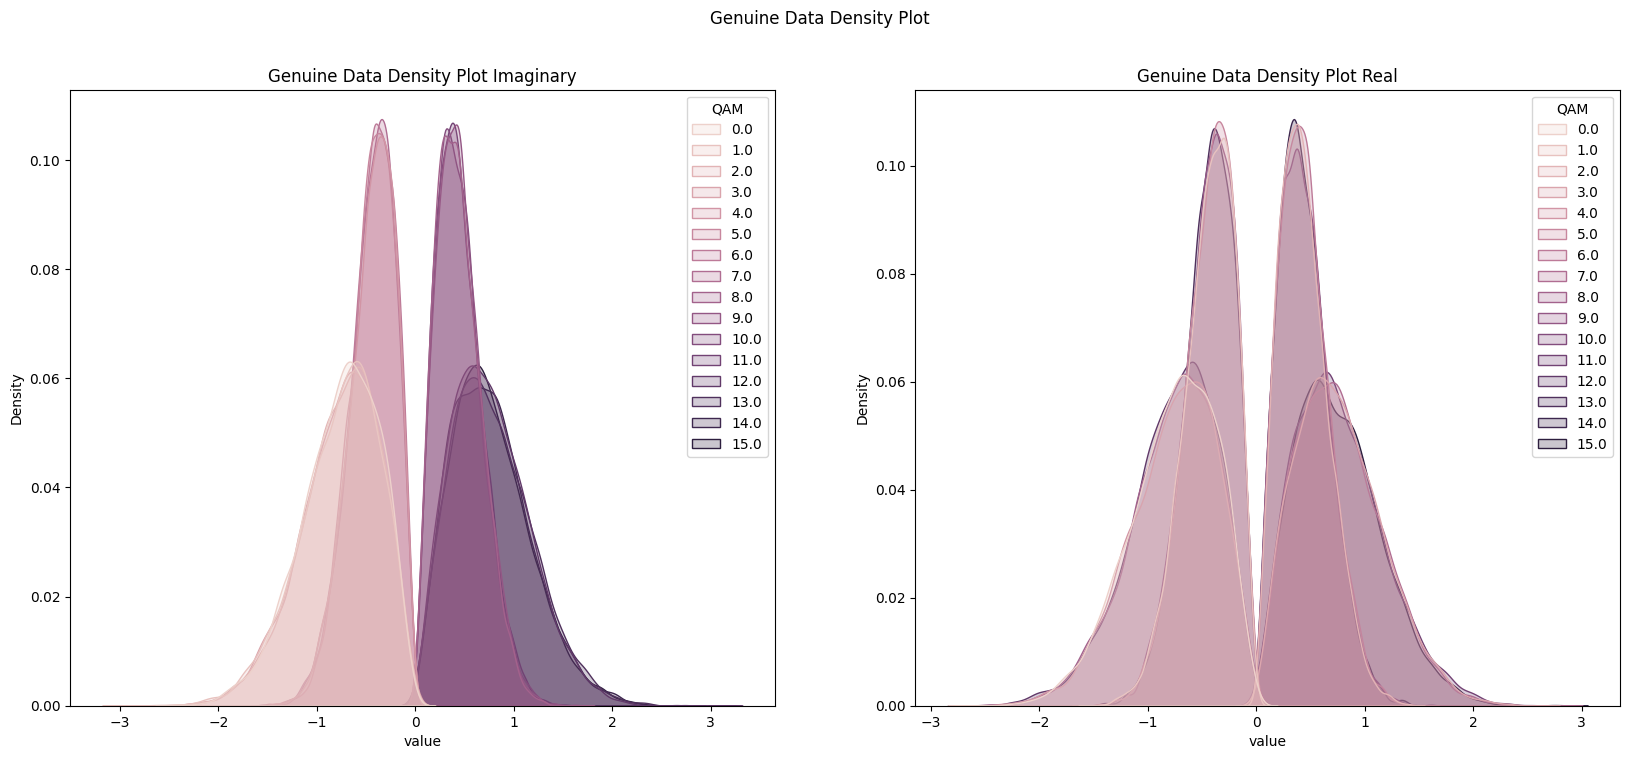

In [27]:
# Melt the data to long-form
data_melted_actual_imaginary = pd.melt(df_genuine_eval, id_vars=['QAM'], value_vars=['real'])
data_melted_actual_real = pd.melt(df_genuine_eval, id_vars=['QAM'], value_vars=['imaginary'])

# Plot the density plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.kdeplot(data=data_melted_actual_imaginary, x='value', hue='QAM', fill=True, ax=ax1)
ax1.set_title("Genuine Data Density Plot Imaginary")

sns.kdeplot(data=data_melted_actual_real, x='value', hue='QAM', fill=True, ax=ax2)
ax2.set_title("Genuine Data Density Plot Real")

fig.suptitle("Genuine Data Density Plot")
plt.show()

### Generated Data

In [28]:
conditional_distribution_index_value = model_eval_git.get_conditional_distribution_index_value_cgan_v1(gen, Z, nakagami_condition, nakagami_indices)
conditional_distribution_index_value = conditional_distribution_index_value[:, :3]

 145/3125 [>.............................] - ETA: 3s

2023-12-10 01:49:58.583287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3125/3125 [==============================] - 3s 1ms/step


In [29]:
df_generated_eval = pd.DataFrame(conditional_distribution_index_value.numpy(), columns=['real', 'imaginary', 'QAM'])
df_generated_eval

,real,imaginary,QAM
0,-0.502895,0.627368,7.0
1,0.294876,0.179082,10.0
2,0.696007,-0.354059,8.0
3,-0.321332,-0.527290,4.0
4,-0.475963,1.253932,3.0
...,...,...,...
99995,0.703401,0.372780,10.0
99996,-0.162213,-0.433635,4.0
99997,0.810568,-0.742396,13.0
99998,0.278864,1.502805,11.0


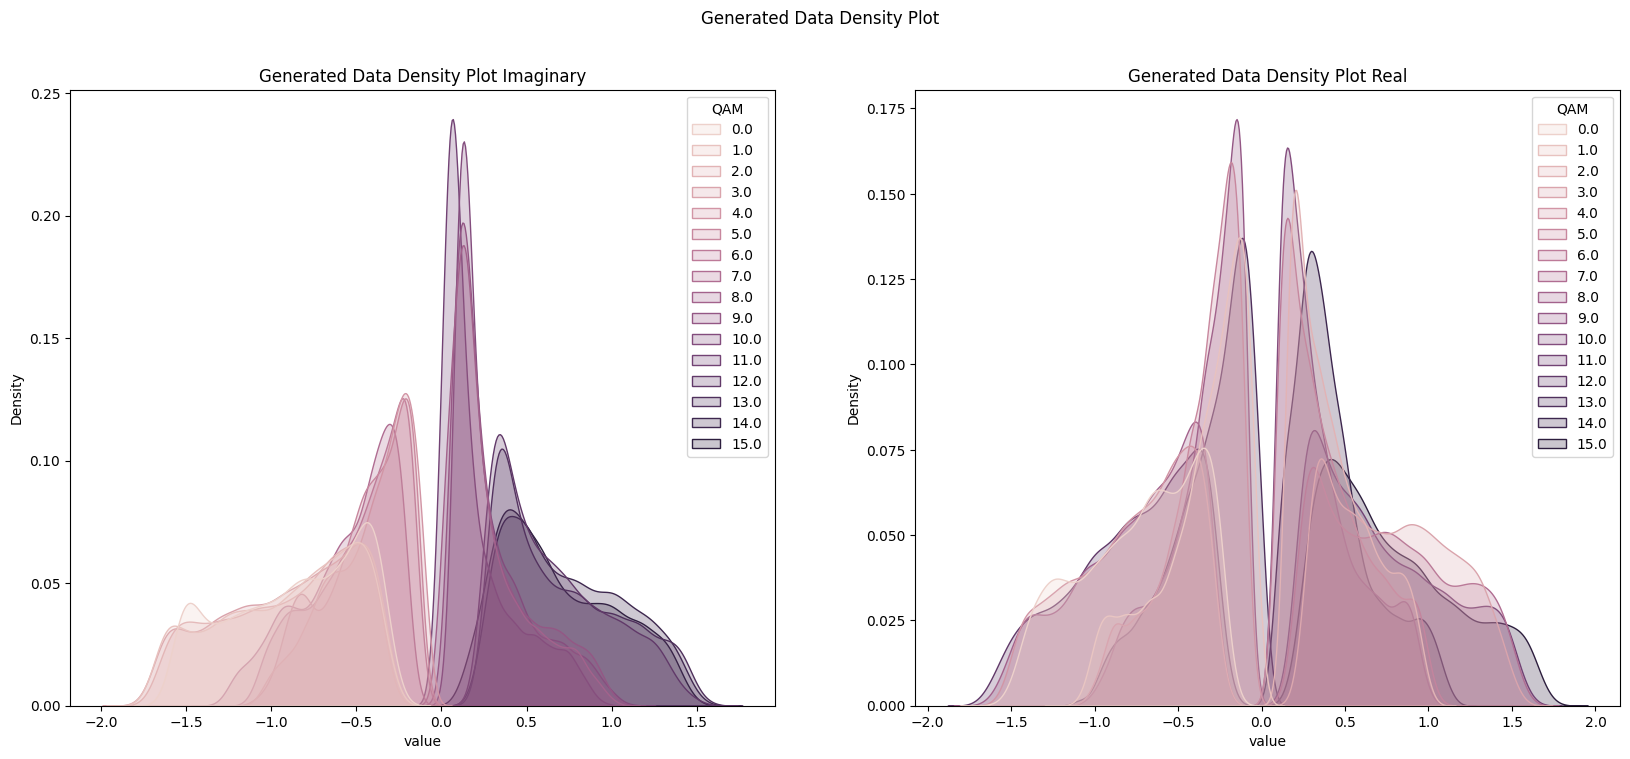

In [30]:
# Melt the data to long-form
data_melted_generated_imaginary = pd.melt(df_generated_eval, id_vars=['QAM'], value_vars=['real'])
data_melted_generated_real = pd.melt(df_generated_eval, id_vars=['QAM'], value_vars=['imaginary'])

# Plot the density plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.kdeplot(data=data_melted_generated_imaginary, x='value', hue='QAM', fill=True, ax=ax1)
ax1.set_title("Generated Data Density Plot Imaginary")

sns.kdeplot(data=data_melted_generated_real, x='value', hue='QAM', fill=True, ax=ax2)
ax2.set_title("Generated Data Density Plot Real")



fig.suptitle("Generated Data Density Plot")
plt.show()

### Overlapped Area

In [31]:
# Melt the data to long-form
data_melted_actual_imaginary = pd.melt(df_genuine_eval, id_vars=['QAM'], value_vars=['real'])
data_melted_actual_real = pd.melt(df_genuine_eval, id_vars=['QAM'], value_vars=['imaginary'])

df_afterward_real = data_melted_actual_real.copy()
df_afterward_real.rename(columns={'value':'genuine_real'}, inplace=True)
df_afterward_real['generated_real'] = data_melted_generated_real['value']
df_afterward_real.drop('variable', axis=1, inplace=True)
df_afterward_real

df_afterward_real_vertical = pd.melt(df_afterward_real, id_vars=['QAM'], value_vars=['genuine_real', 'generated_real'],
                      var_name='aux', value_name='data').sort_values(by='aux', ascending=False)

df_afterward_imaginary = data_melted_actual_imaginary.copy()
df_afterward_imaginary.rename(columns={'value':'genuine_imaginary'}, inplace=True)
df_afterward_imaginary['generated_imaginary'] = data_melted_generated_imaginary['value']
df_afterward_imaginary.drop('variable', axis=1, inplace=True)
df_afterward_imaginary

df_afterward_imaginary_vertical = pd.melt(df_afterward_imaginary, id_vars=['QAM'], value_vars=['genuine_imaginary', 'generated_imaginary'],
                      var_name='aux', value_name='data').sort_values(by='aux', ascending=False)


#### __Real__

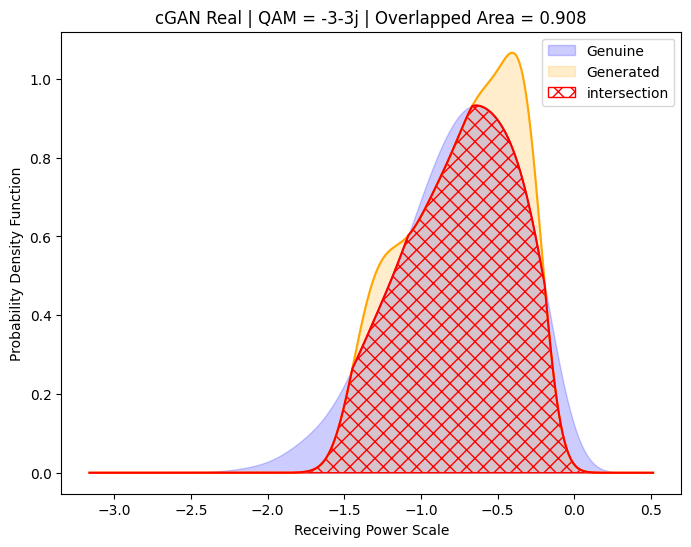

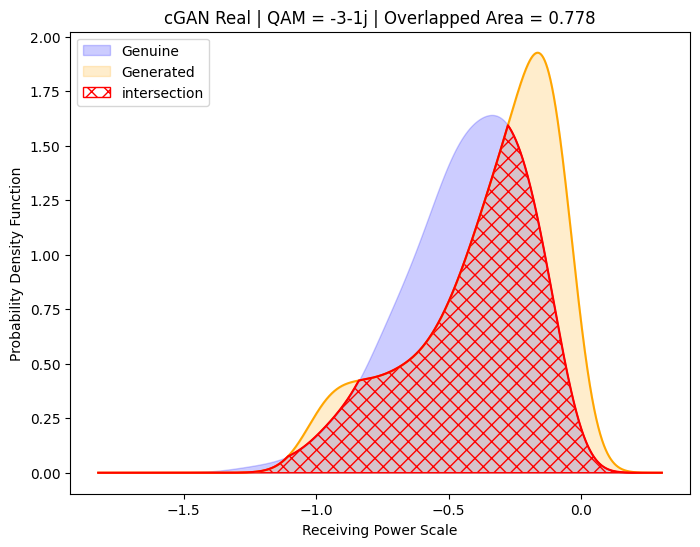

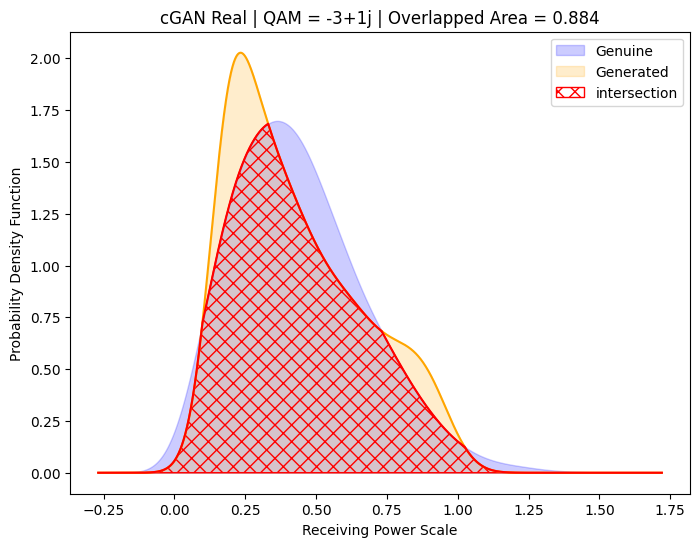

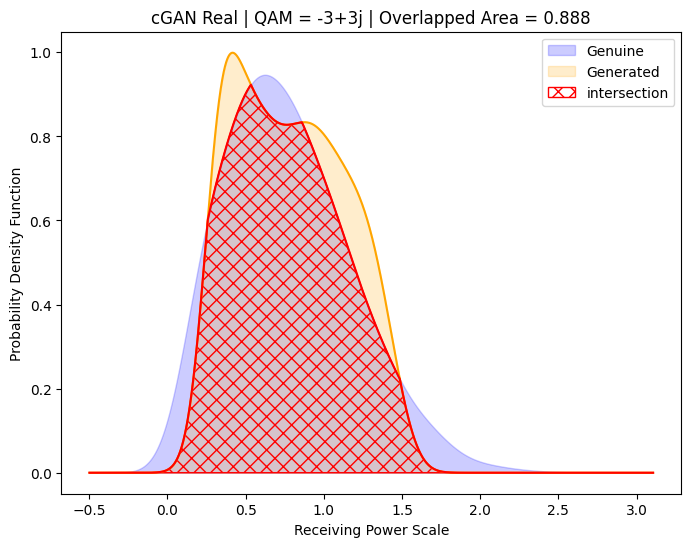

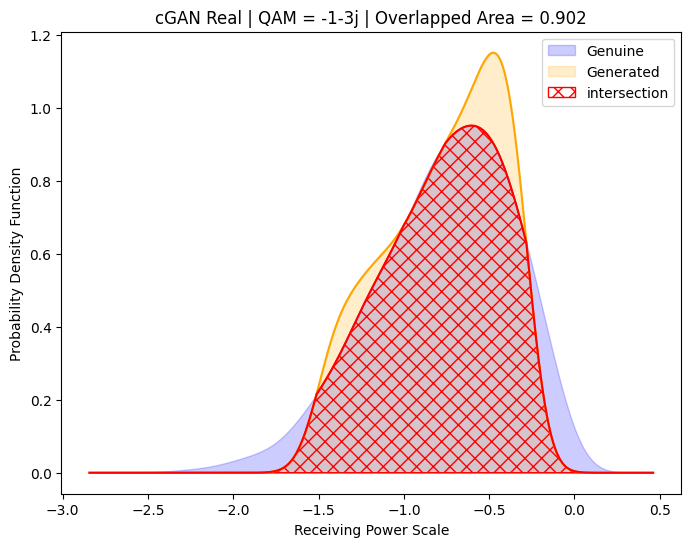

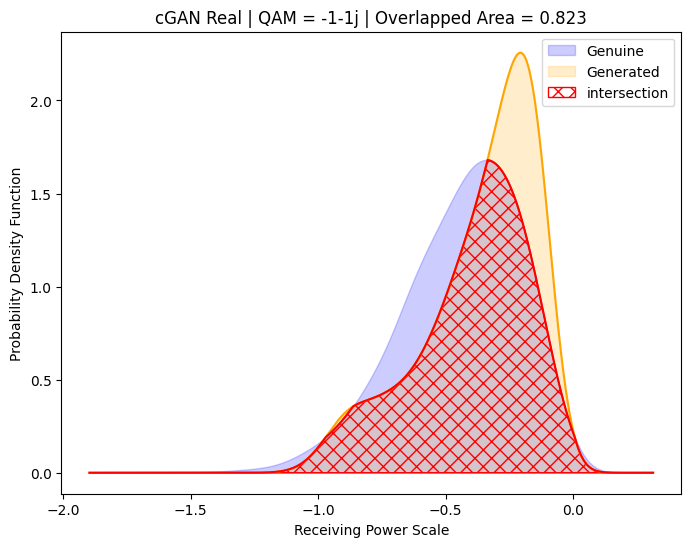

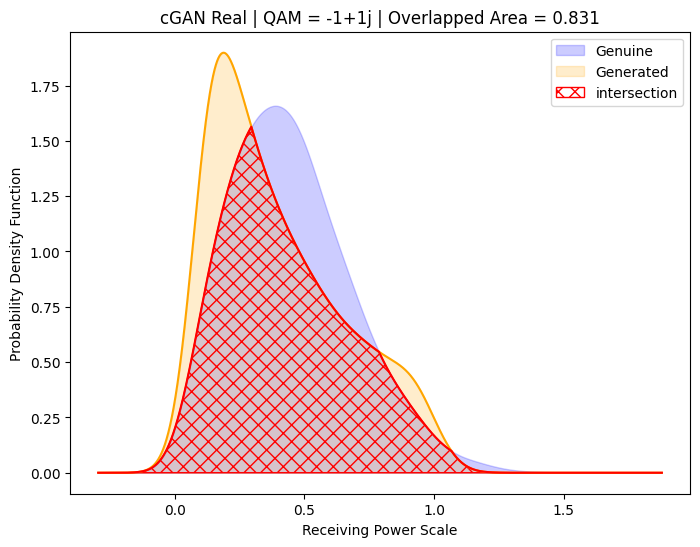

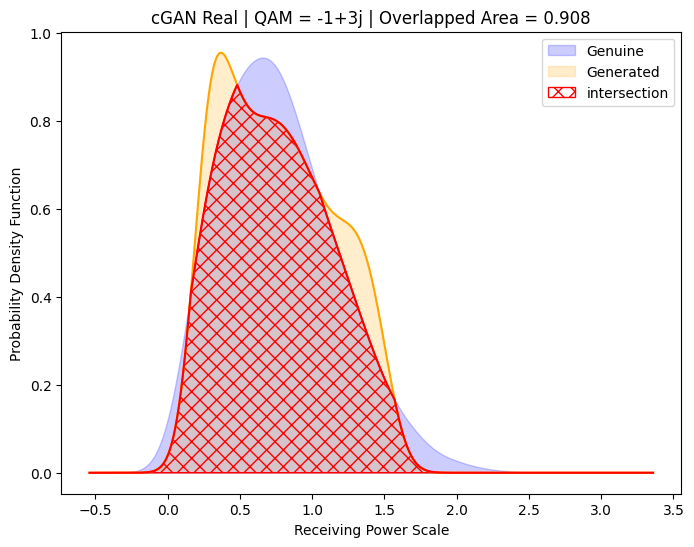

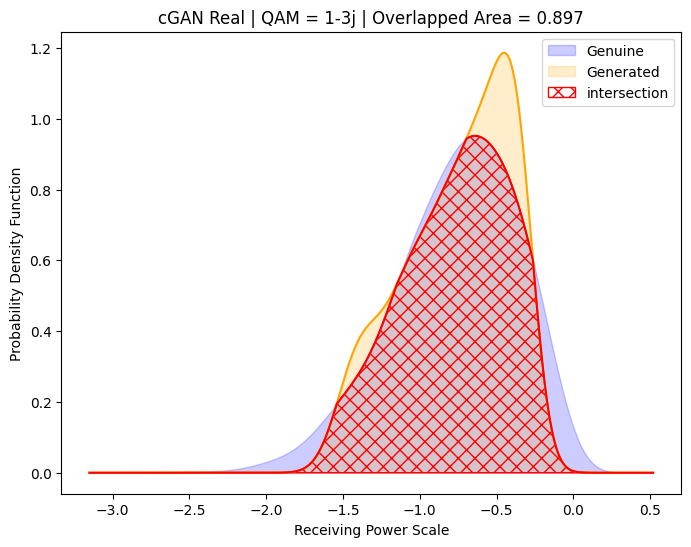

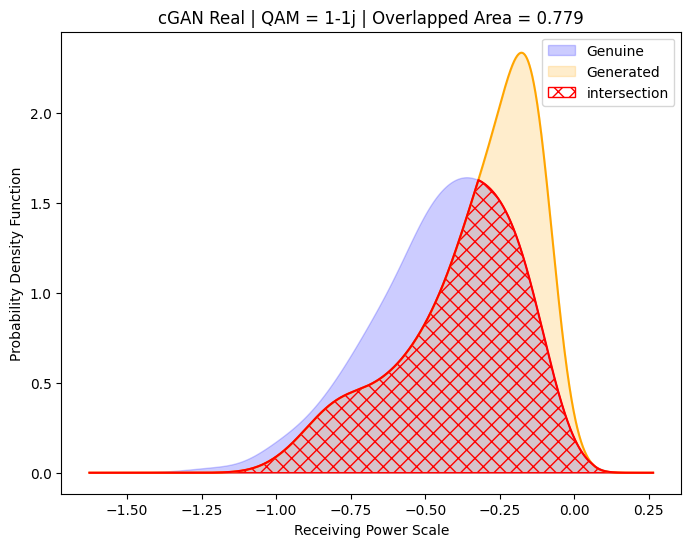

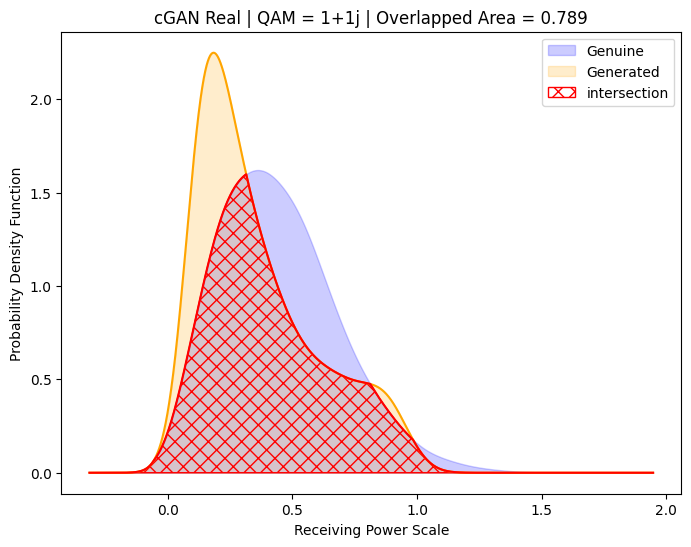

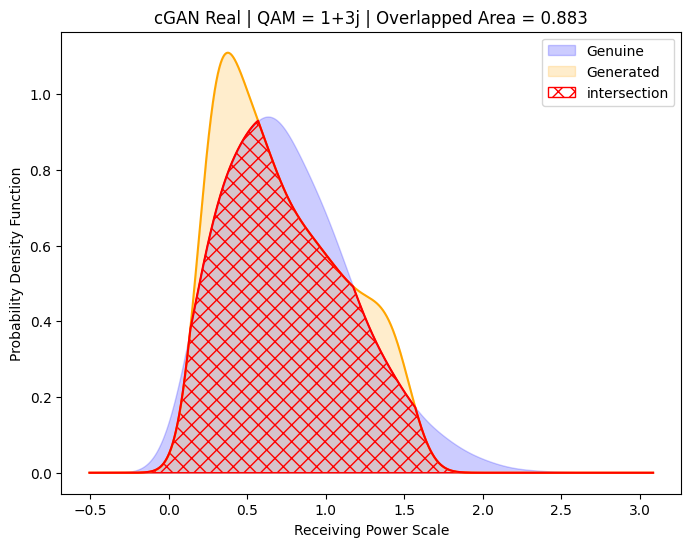

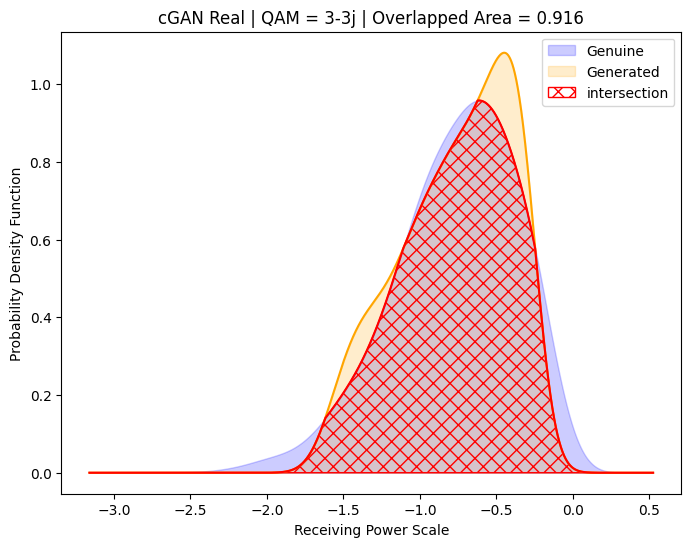

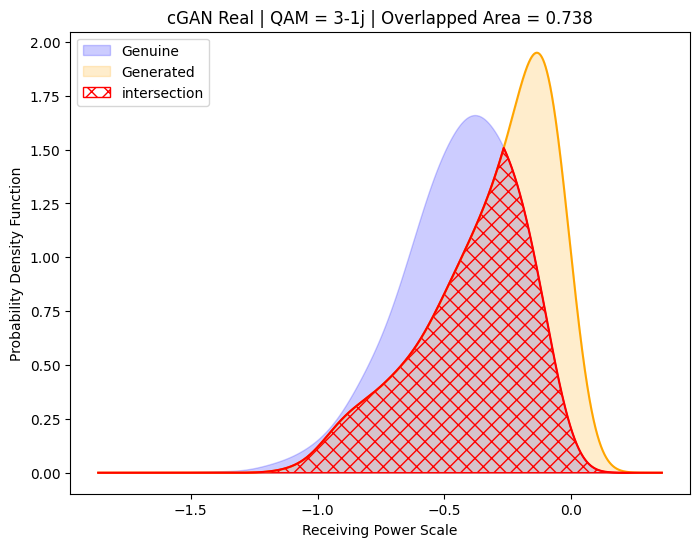

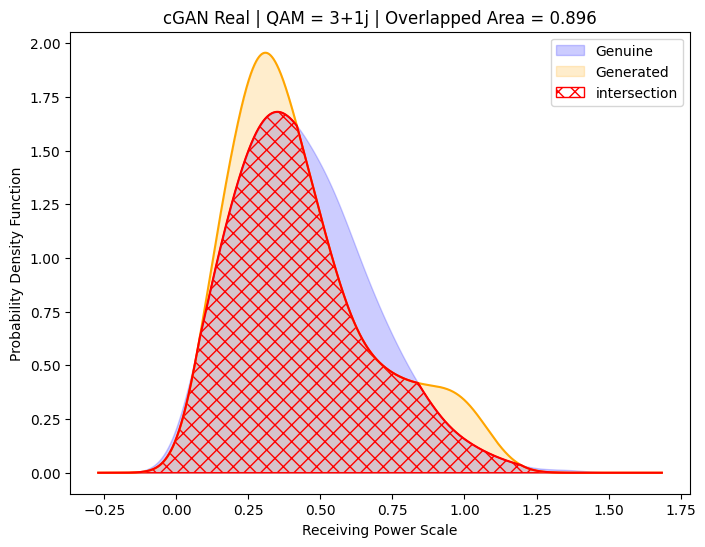

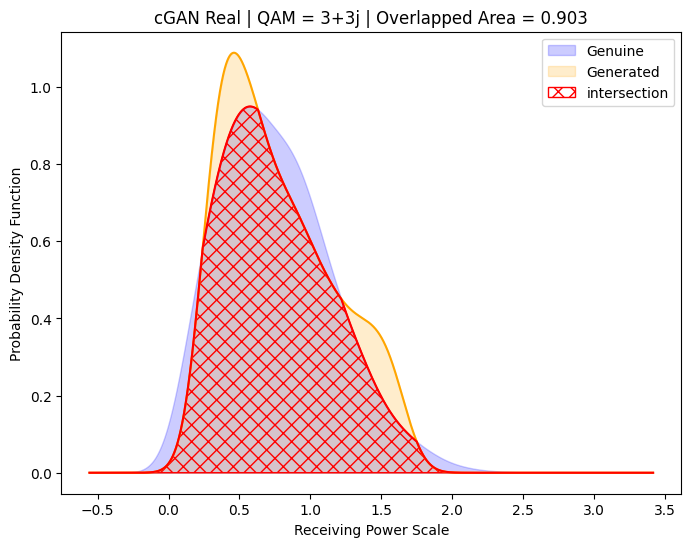

In [32]:
# https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

QAM = con.QAM
list_for_df_real = list()
for i in range(len(df_afterward_real_vertical['QAM'].unique())):

    fig, ax = plt.subplots(figsize=(8, 6))
    
    x0 = df_afterward_real[df_afterward_real['QAM'] == i]['genuine_real']
    x1 = df_afterward_real[df_afterward_real['QAM'] == i]['generated_real']

    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)
    
    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx
    
    x = np.linspace(xmin, xmax, len(x0))
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    plt.fill_between(x, kde0_x, 0, color='b', alpha=0.2, label='Genuine')
    plt.plot(x, kde1_x, color='orange')
    plt.fill_between(x, kde1_x, 0, color='orange', label='Generated', alpha=0.2)
    plt.plot(x, inters_x, color='r')
    plt.fill_between(x, inters_x, 0, facecolor='none', edgecolor='r', hatch='xx', label='intersection')
    
    area_inters_x = np.trapz(inters_x, x)
    
    list_for_df_real.append([i, area_inters_x])

    qam_img = str(int(QAM[i].imag)) if QAM[i].imag < 0 else "+" + str(int(QAM[i].imag))
    ax.set_title(f"cGAN Real | QAM = {int(QAM[i].real)}{qam_img}j | Overlapped Area = {area_inters_x:.3f}")
    os.makedirs('./FFN_ap1_kde_real', exist_ok=True)
    
    plt.xlabel('Receiving Power Scale')
    plt.ylabel('Probability Density Function')
    plt.legend()

    plt.show()


In [33]:
df_oa_real = pd.DataFrame(list_for_df_real, columns=['d', 'area_overlapped'])
print(f"Average Overlapped Area Real = {df_oa_real['area_overlapped'].mean()}")
df_oa_real

Average Overlapped Area Real = 0.8576223544484127


,d,area_overlapped
0,0,0.907830
1,1,0.778225
2,2,0.883762
3,3,0.887686
4,4,0.902402
5,5,0.822836
6,6,0.831202
7,7,0.907828
8,8,0.896557
9,9,0.778866


#### __Imaginary__

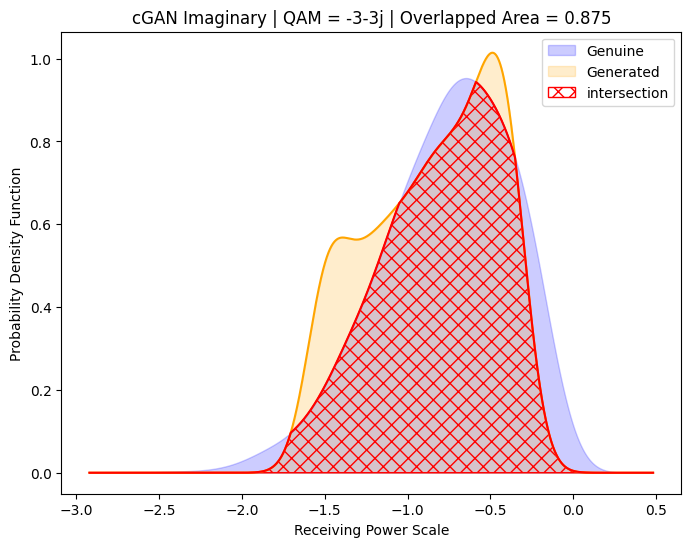

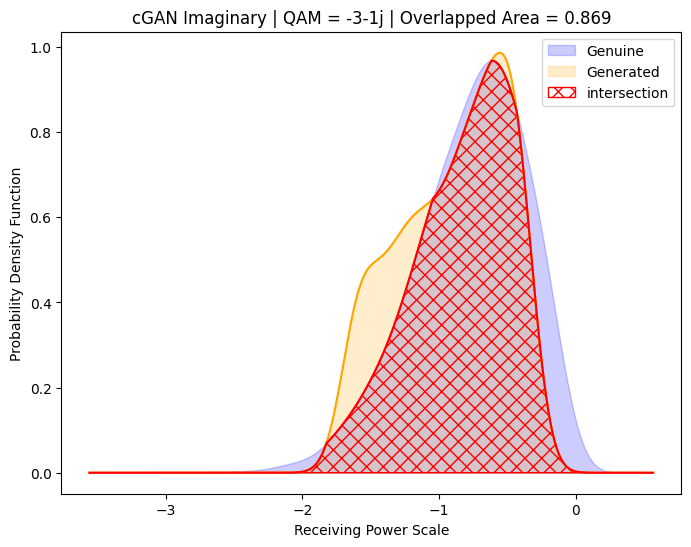

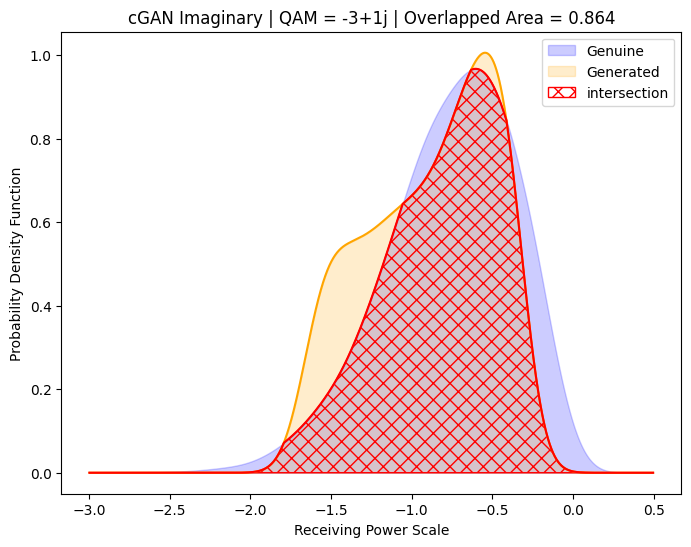

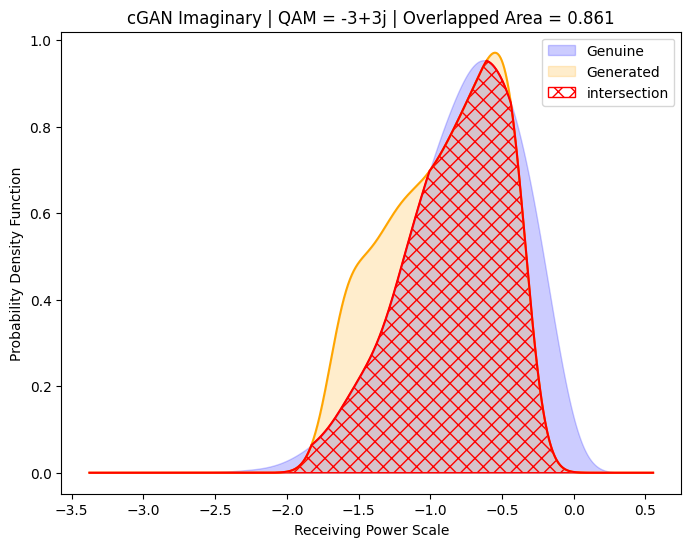

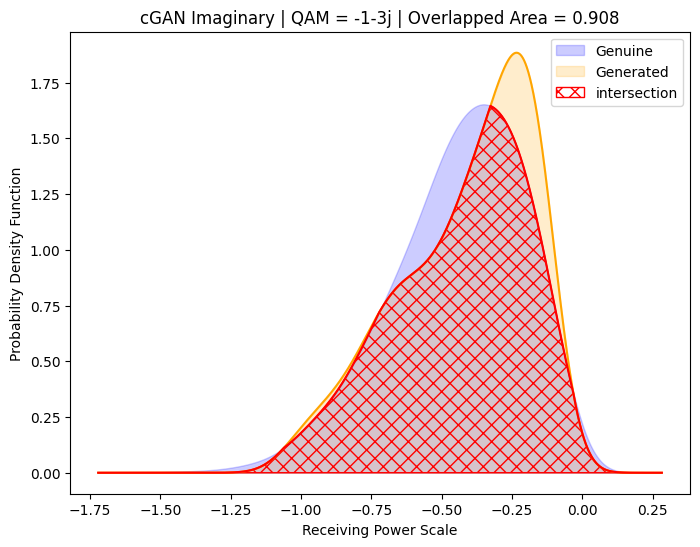

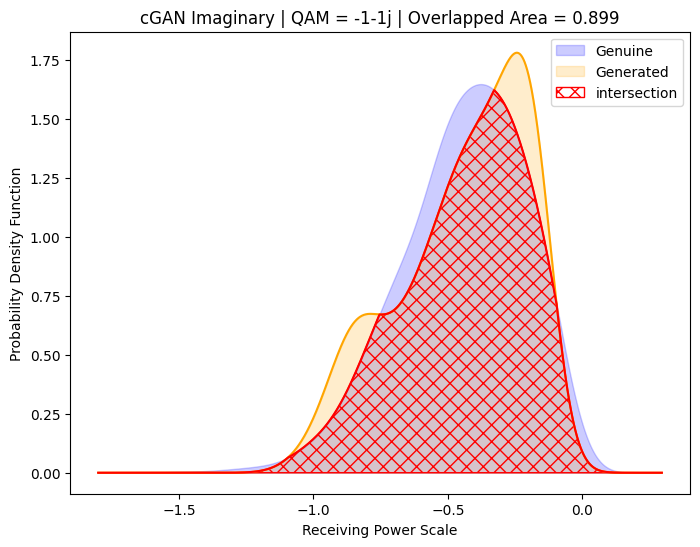

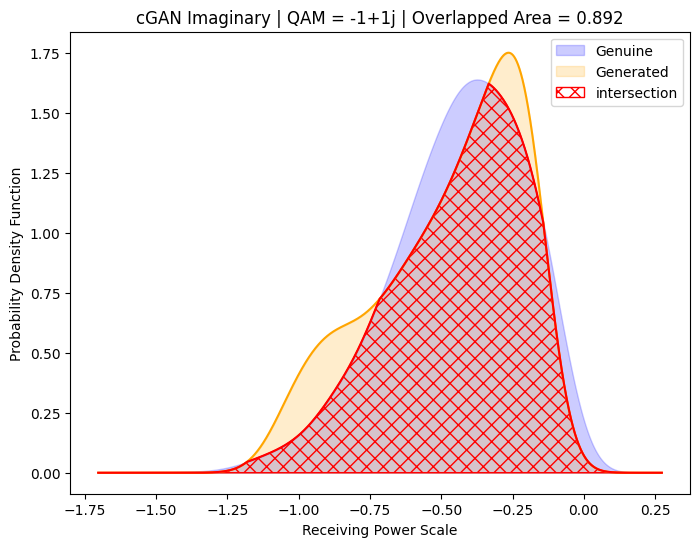

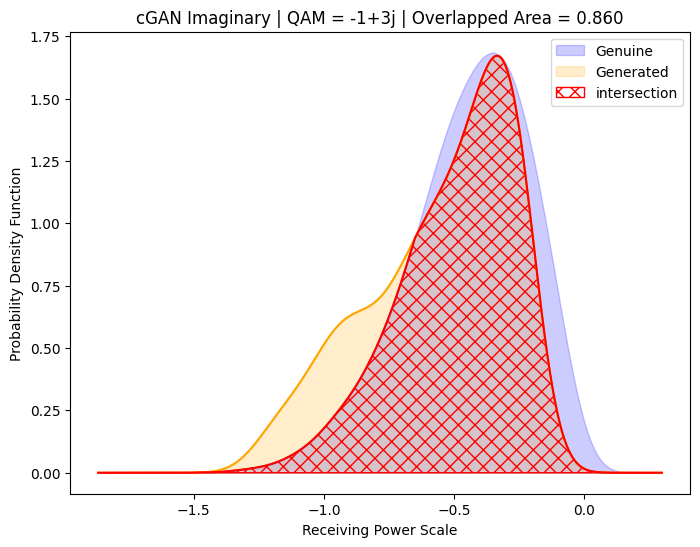

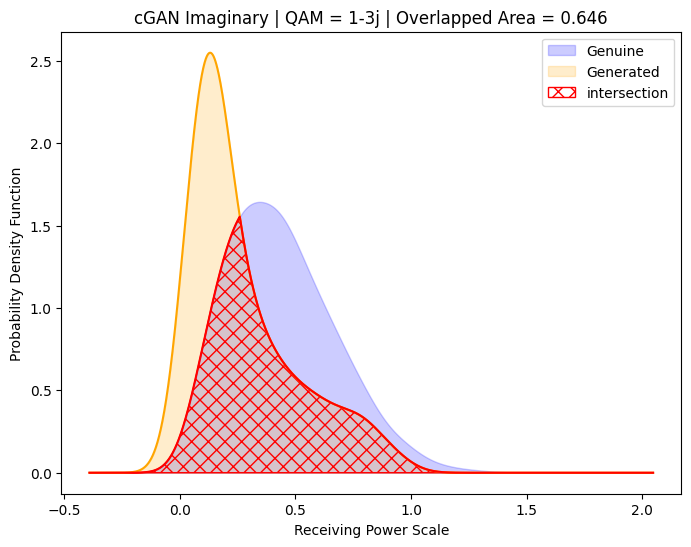

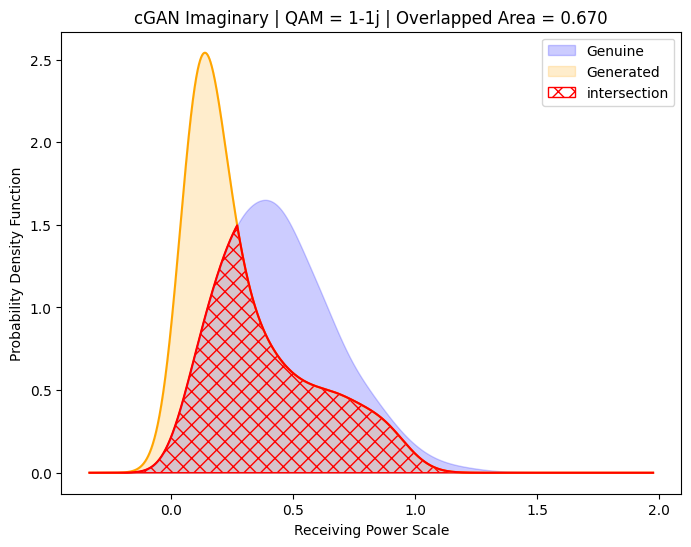

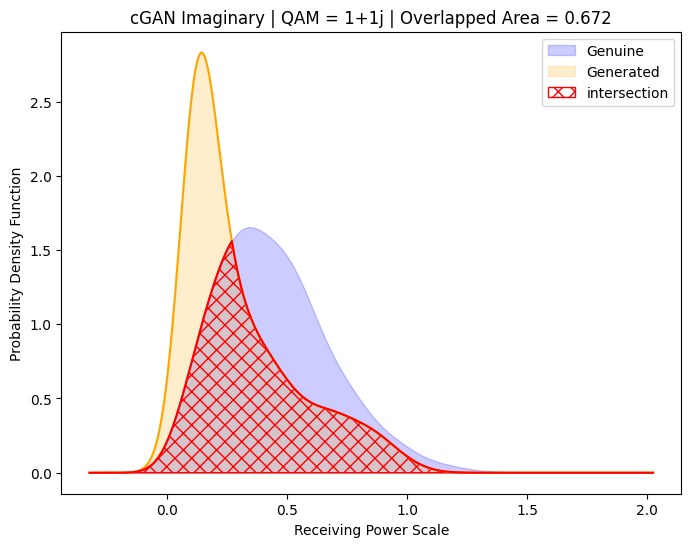

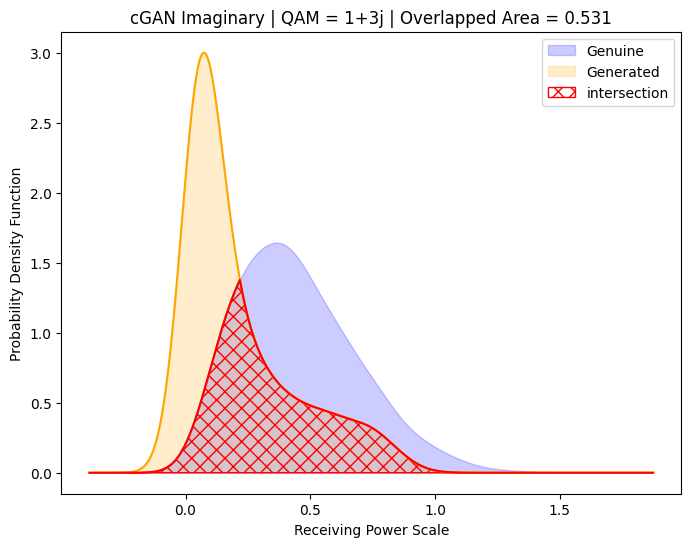

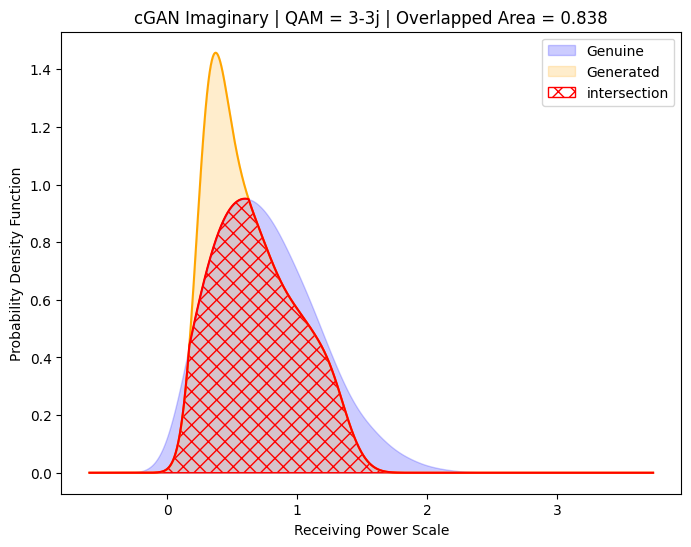

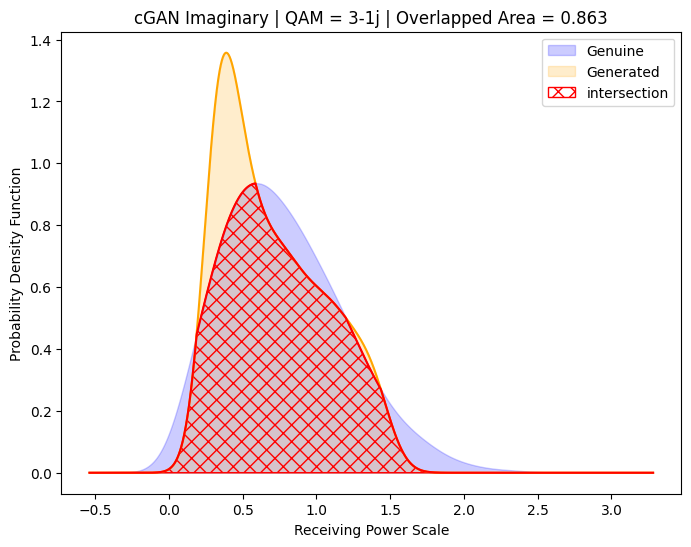

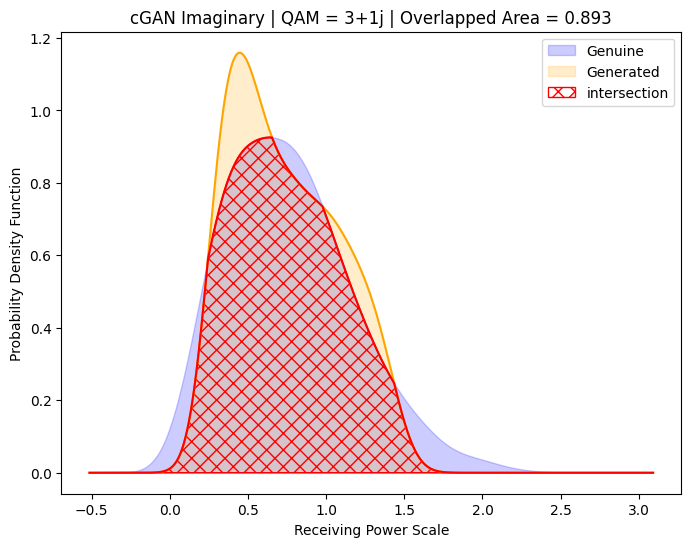

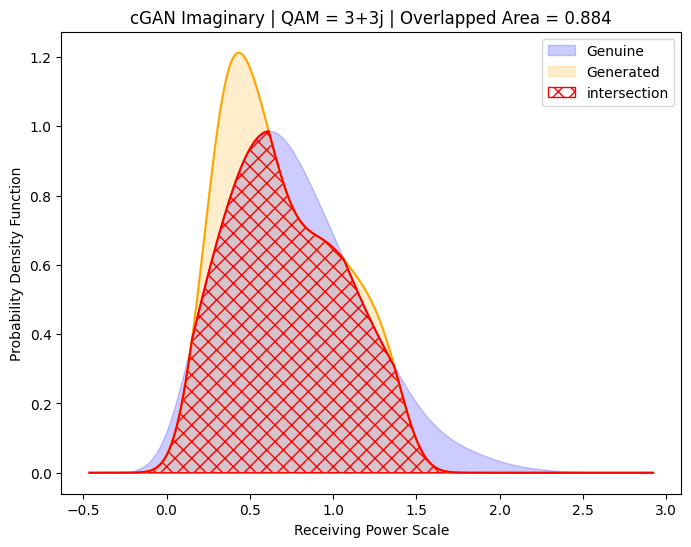

In [34]:
# https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

QAM = con.QAM
list_for_df_imag = list()
for i in range(len(df_afterward_real_vertical['QAM'].unique())):

    fig, ax = plt.subplots(figsize=(8, 6))
    
    x0 = df_afterward_imaginary[df_afterward_imaginary['QAM'] == i]['genuine_imaginary']
    x1 = df_afterward_imaginary[df_afterward_imaginary['QAM'] == i]['generated_imaginary']

    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)
    
    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx
    
    x = np.linspace(xmin, xmax, len(x0))
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    plt.fill_between(x, kde0_x, 0, color='b', alpha=0.2, label='Genuine')
    plt.plot(x, kde1_x, color='orange')
    plt.fill_between(x, kde1_x, 0, color='orange', label='Generated', alpha=0.2)
    plt.plot(x, inters_x, color='r')
    plt.fill_between(x, inters_x, 0, facecolor='none', edgecolor='r', hatch='xx', label='intersection')
    
    area_inters_x = np.trapz(inters_x, x)
    
    list_for_df_imag.append([i, area_inters_x])

    qam_img = str(int(QAM[i].imag)) if QAM[i].imag < 0 else "+" + str(int(QAM[i].imag))
    ax.set_title(f"cGAN Imaginary | QAM = {int(QAM[i].real)}{qam_img}j | Overlapped Area = {area_inters_x:.3f}")
    
    plt.xlabel('Receiving Power Scale')
    plt.ylabel('Probability Density Function')
    plt.legend()

    plt.show()


In [35]:
df_oa_imag = pd.DataFrame(list_for_df_imag, columns=['d', 'area_overlapped'])
print(f"Average Overlapped Area Imaginary = {df_oa_imag['area_overlapped'].mean()}")
df_oa_imag

Average Overlapped Area Imaginary = 0.8140256135433837


,d,area_overlapped
0,0,0.874545
1,1,0.869140
2,2,0.864472
3,3,0.860567
4,4,0.907514
5,5,0.899008
6,6,0.891518
7,7,0.859768
8,8,0.646487
9,9,0.669934


1/1 [==============================] - 0s 25ms/step


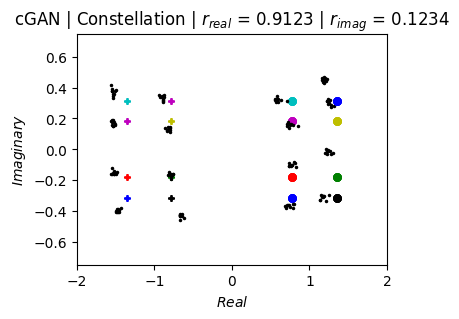

<Figure size 640x480 with 0 Axes>

In [36]:
colors = ['b+', 'r+', 'm+', 'c+', 'k+', 'g+', 'y+', 'm+', \
        'bo', 'ro', 'mo', 'co', 'ko', 'go', 'yo', 'bo']
QAM = con.QAM
m = con.m
eta = con.eta
alpha = con.alpha
d = con.d
d_0 = con.d_0

samples = np.array([])
for channel_idx in range(1):
    number = 10  #
    r_real = np.array([0.9123]) 
    r_imaginary = np.array([0.1234]) 
    r_real = np.tile(r_real, number)
    r_imaginary = np.tile(r_imaginary, number)
    
    fig, ax = plt.subplots(figsize=(4, 3))
    
    for idx in range(len(QAM)):
        labels_index = np.tile(idx, number)
        Pt = QAM[labels_index]
        
        RHS_real = gammaincinv(m, gamma(m)*r_real) / m
        RHS_imaginary = gammaincinv(m, gamma(m)*r_imaginary) / m

        Pr_d = Pt * eta * np.power((d_0/d), alpha)
        
        data_real = np.real(Pr_d) * RHS_real
        data_imaginary = np.imag(Pr_d) * RHS_imaginary
        
        sign_data_real = con.sign_checker_array(data_real)
        sign_data_imaginary = con.sign_checker_array(data_imaginary)

        # data_real(imaginary)_sign is -1 (if negative) 0 (if zero) 1 (if positive)
        # because np.sqrt(negative_number) is impossible in numpy
        nakagami_real = sign_data_real * np.sqrt(abs(data_real))
        nakagami_imaginary = sign_data_imaginary * np.sqrt(abs(data_imaginary))

        transmit_data = np.hstack((nakagami_real.reshape(len(Pt), 1),
                                nakagami_imaginary.reshape(len(Pt), 1)))
        
        conditioning = np.hstack(
            (np.real(Pt).reshape(len(Pt), 1)/3, np.imag(Pt).reshape(len(Pt), 1)/3,
            r_real.reshape(len(Pt), 1), r_imaginary.reshape(len(Pt), 1)))
        
        samples_component = gen.predict([Z[:number], conditioning])

        plt.plot(transmit_data[:, 0], transmit_data[:, 1], colors[idx], markersize=5)
        plt.plot(samples_component[:, 0], samples_component[:, 1], 'k.', markersize=3)
  
    plt.title(f"cGAN | Constellation | $r_{{real}}$ = {r_real[0]} | $r_{{imag}}$ = {r_imaginary[0]}")
    
    axes = plt.gca()
    axes.set_xlim([-2., 2.])
    axes.set_ylim([-0.75, 0.75])
    xlabel = r'$Real$'
    ylabel = r'$Imaginary$'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show()

plt.clf()

### Generated Data Evalulation

#### Mean

In [37]:
df_mean_comp = pd.concat([df_generated_eval.groupby('QAM').mean(), df_ideal_mean], axis=1)
df_per_diff_mean_real = (((df_mean_comp['real'] - df_mean_comp['ideal_real']) / df_mean_comp['ideal_real']) * 100).round(2)
df_per_diff_mean_imaginary = (((df_mean_comp['imaginary'] - df_mean_comp['ideal_imaginary']) / df_mean_comp['ideal_imaginary']) * 100).round(2)
df_per_diff_mean_dict = {'per_diff_real_%':df_per_diff_mean_real, 'per_diff_imaginary_%':df_per_diff_mean_imaginary}
df_mean_comp_final = pd.concat([df_mean_comp, pd.DataFrame(df_per_diff_mean_dict)], axis=1)
df_mean_comp_final[df_mean_comp_final.columns[[0, 2, 4, 1, 3, 5]]]

,real,ideal_real,per_diff_real_%,imaginary,ideal_imaginary,per_diff_imaginary_%
0.0,-0.858700,-0.767495,11.88,-0.733643,-0.767495,-4.41
1.0,-0.903747,-0.767495,17.75,-0.358006,-0.443113,-19.21
2.0,-0.891025,-0.767495,16.10,0.430898,0.443113,-2.76
3.0,-0.912276,-0.767495,18.86,0.786333,0.767495,2.45
4.0,-0.416170,-0.443113,-6.08,-0.771685,-0.767495,0.55
5.0,-0.445769,-0.443113,0.60,-0.363309,-0.443113,-18.01
6.0,-0.476028,-0.443113,7.43,0.398416,0.443113,-10.09
7.0,-0.554213,-0.443113,25.07,0.764868,0.767495,-0.34
8.0,0.270114,0.443113,-39.04,-0.759337,-0.767495,-1.06
9.0,0.301172,0.443113,-32.03,-0.340729,-0.443113,-23.11


#### Variance

In [38]:
df_var_comp = pd.concat([df_generated_eval.groupby('QAM').var(), df_ideal_var], axis=1)
df_per_diff_var_real = (((df_var_comp['real'] - df_var_comp['ideal_real']) / df_var_comp['ideal_real']) * 100).round(2)
df_per_diff_var_imaginary = (((df_var_comp['imaginary'] - df_var_comp['ideal_imaginary']) / df_var_comp['ideal_imaginary']) * 100).round(2)
df_per_diff_var_dict = {'per_diff_real_%':df_per_diff_var_real, 'per_diff_imaginary_%':df_per_diff_var_imaginary}
df_var_comp_final = pd.concat([df_var_comp, pd.DataFrame(df_per_diff_var_dict)], axis=1)
df_var_comp_final[df_var_comp_final.columns[[0, 2, 4, 1, 3, 5]]]

,real,ideal_real,per_diff_real_%,imaginary,ideal_imaginary,per_diff_imaginary_%
0.0,0.143531,0.160951,-10.82,0.121070,0.160951,-24.78
1.0,0.153240,0.160951,-4.79,0.068529,0.053650,27.73
2.0,0.149512,0.160951,-7.11,0.052545,0.053650,-2.06
3.0,0.149283,0.160951,-7.25,0.118709,0.160951,-26.25
4.0,0.055553,0.053650,3.55,0.115241,0.160951,-28.40
5.0,0.056455,0.053650,5.23,0.049195,0.053650,-8.31
6.0,0.064454,0.053650,20.14,0.062748,0.053650,16.96
7.0,0.073117,0.053650,36.28,0.142373,0.160951,-11.54
8.0,0.052522,0.053650,-2.10,0.119059,0.160951,-26.03
9.0,0.058195,0.053650,8.47,0.048291,0.053650,-9.99
